In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Mounted at /content/drive


# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](https://drive.google.com/uc?export=view&id=1umMZeIdvBK-xpYmkDL4d-LchrDfmD7e2)

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [4]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from imutils import paths
from cv2 import cv2
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()
#%%
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from loader_util.datasets import CustomTorchDataset, train_test_split_paths 
#%%

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="https://drive.google.com/uc?export=view&id=1ckPsRpYfwpTI9cdGCUSrUPQukjda-PVD" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [6]:
# define location to train/validation datasets
train_valid_path = r"/content/drive/MyDrive/ImageDatasets/landmark_images/train"
test_path = r"/content/drive/MyDrive/ImageDatasets/landmark_images/test"

In [7]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(30)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

valid_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])


# get the randomised train and validation image paths through utility function
trainPaths, validPaths = train_test_split_paths(train_valid_path)

# define the custom datasets
train_data = CustomTorchDataset(pathList=trainPaths,
                                tranforms=train_transform)
valid_data = CustomTorchDataset(pathList=validPaths, 
                                  tranforms=valid_transforms)
test_data = CustomTorchDataset(pathList=list(paths.list_images(test_path)), 
                                 tranforms=valid_transforms)

# construct the dataloaders
batch_size = 32
num_workers = 0

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# define the loader scratch dictionary
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


In [ ]:
print(f"train_data: {len(train_data)}.....valid_data: {len(valid_data)}.....test_data: {len(test_data)}")

train_data: 3497.....valid_data: 1499.....test_data: 1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

- The implemented code makes use of built in torch transforms to resize images and to convert them to tensors. The size for the input tensor was chosen to be 224px x 224px. 224px size images is the standard size for many state of the art CNN architectures like VGG16 and hence this size was chosen for the input tensor so that when we are applying transfer learning, we can easily pass the preprocessed images through pretrained networks.

- The dataset was augmented through transformations like random rotations and random flips. The augmentation was only applied on the training data and was applied to reduce overfitting of CNN models on the small amount of image data that we have.

- It is to be noted that this code makes use of [`CustomTorchDataset`](https://github.com/nombreinvicto/DeepLearning/blob/master/loader_util/datasets/torch_dataset_loader.py) and [`train_test_split_paths`](https://github.com/nombreinvicto/DeepLearning/blob/master/loader_util/datasets/torch_train_test_split.py) functions to do train/validation/test splits on the image data and to create appropriate datasets. I have coded these functions and have provided them as hyperlinks.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
def imshow(image):
  image = (image * 0.5) + 0.5
  plt.imshow(np.transpose(image, (1, 2, 0)))

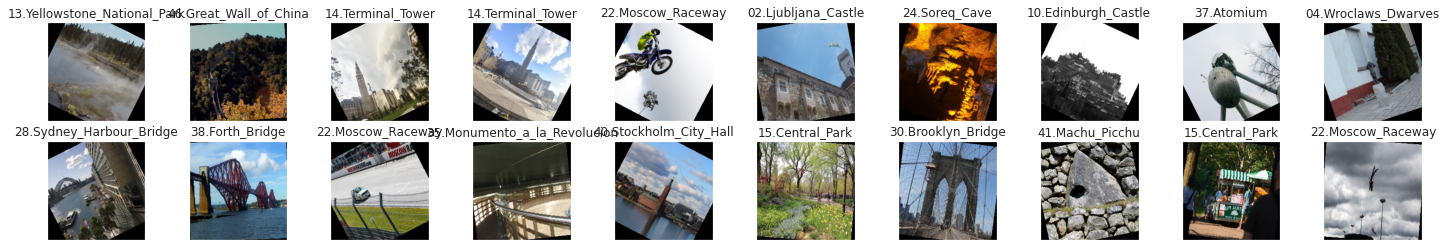

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(train_data.classes[labels[idx]])

### Initialize use_cuda variable

In [9]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [ ]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    opt = optim.SGD(model.parameters(), lr=0.01)
    return opt

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [ ]:
# define the CNN architecture
class LeNet(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def forward(self, x):
      ## Define forward behavior
      x = self.conv_layer1(x)
      x = self.fc_layers(x)
      return x
    def __init__(self):
        super(LeNet, self).__init__()
        
        ## Define layers of a CNN
        # conv_section -1
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.fc_layers = nn.Sequential(
              nn.Flatten(),
              nn.Linear(100352, 128),
              nn.ReLU(),
              nn.BatchNorm1d(128),
              nn.Linear(128, len(train_data.classes))
        )
    
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = LeNet()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [ ]:
summary(model_scratch, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,432
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          51,264
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]         204,928
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
          Flatten-10               [-1, 100352]               0
           Linear-11                  [-1, 128]      12,845,184
             ReLU-12                  [-1, 128]               0
      BatchNorm1d-13                  [-1, 128]             256
           Linear-14                   

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

- We have a very small amount of image data. Hence, we needed to come up with a CNN architecture that is not too deep that it would start overfitting on the data. At the same time, we needed to make sure that the architecture would be deep enough that it would be able to learn discriminatory features from the data. The proposed CNN model is inspired from the famous LeNET architecture that was used to identify hand written digits from small images. 

- The architecture involves 2D CNN convolutional layers used to extract features from the 224px RGB images. MaxPooling layers are there mainly for dimensional reduction and a BatchNormalisation layer was added to introduce regularisation effect further down the depth of the architecture.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            # clear gradients
            optimizer.zero_grad()

            #forward pass
            output = model(data)

            # calculate loss
            loss = criterion(output, target)

            # backward pass
            loss.backward()

            # perform single step
            optimizer.step()

            train_loss += loss.item() * data.size(0)


        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 

            #  forward pass
            output = model(data)

            #calculate loss
            loss = criterion(output, target)

            # update validation loss
            valid_loss += loss.item() * data.size(0)


        #calculate average losses
        train_loss = train_loss / len(train_data)    
        valid_loss = valid_loss / len(valid_data)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
          print(f"Validation loss decreased   ({valid_loss_min:0.6f} ---> {valid_loss:0.6f}. Saving model.....)")
          torch.save(model.state_dict(), f"/content/drive/MyDrive/ImageDatasets/images/saved_model/{save_path}")
          valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [ ]:
def custom_weight_init(layer):
    ## TODO: implement a weight initialization strategy
    if isinstance(layer, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(layer.weight)
    if isinstance(layer, torch.nn.Linear):
        n = layer.in_features
        y = 1.0 / (np.sqrt(n))
        torch.nn.init.normal_(layer.weight, mean=0, std=y)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.702172 	Validation Loss: 3.707612
Validation loss decreased   (inf ---> 3.707612. Saving model.....)
Epoch: 2 	Training Loss: 3.386890 	Validation Loss: 3.598300
Validation loss decreased   (3.707612 ---> 3.598300. Saving model.....)
Epoch: 3 	Training Loss: 3.227921 	Validation Loss: 3.532857
Validation loss decreased   (3.598300 ---> 3.532857. Saving model.....)
Epoch: 4 	Training Loss: 3.062750 	Validation Loss: 3.535515
Epoch: 5 	Training Loss: 2.945933 	Validation Loss: 3.369429
Validation loss decreased   (3.532857 ---> 3.369429. Saving model.....)
Epoch: 6 	Training Loss: 2.807020 	Validation Loss: 3.404122
Epoch: 7 	Training Loss: 2.704699 	Validation Loss: 3.290401
Validation loss decreased   (3.369429 ---> 3.290401. Saving model.....)
Epoch: 8 	Training Loss: 2.575095 	Validation Loss: 3.339108
Epoch: 9 	Training Loss: 2.429382 	Validation Loss: 3.361026
Epoch: 10 	Training Loss: 2.340869 	Validation Loss: 3.466320
Epoch: 11 	Training Loss: 2.208774

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [ ]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.738717 	Validation Loss: 3.657351
Validation loss decreased   (inf ---> 3.657351. Saving model.....)
Epoch: 2 	Training Loss: 3.471930 	Validation Loss: 3.620097
Validation loss decreased   (3.657351 ---> 3.620097. Saving model.....)
Epoch: 3 	Training Loss: 3.300821 	Validation Loss: 3.418269
Validation loss decreased   (3.620097 ---> 3.418269. Saving model.....)
Epoch: 4 	Training Loss: 3.165558 	Validation Loss: 3.319141
Validation loss decreased   (3.418269 ---> 3.319141. Saving model.....)
Epoch: 5 	Training Loss: 3.026084 	Validation Loss: 3.257057
Validation loss decreased   (3.319141 ---> 3.257057. Saving model.....)
Epoch: 6 	Training Loss: 2.894520 	Validation Loss: 3.228092
Validation loss decreased   (3.257057 ---> 3.228092. Saving model.....)
Epoch: 7 	Training Loss: 2.766522 	Validation Loss: 3.094464
Validation loss decreased   (3.228092 ---> 3.094464. Saving model.....)
Epoch: 8 	Training Loss: 2.654756 	Validation Loss: 3.068666
Validation lo

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('/content/drive/MyDrive/ImageDatasets/images/saved_model/model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.783488


Test Accuracy: 31% (393/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [ ]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    opt = optim.SGD(model.classifier.parameters(), lr=0.001)
    return opt

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
## TODO: Specify model architecture

# get a cgg16 pretrained model
model_transfer = models.vgg16(pretrained=True)

# freeze all feature params
for param in model_transfer.features.parameters():
  param.requires_grad = False

# add new last layer for transfer learning
model_transfer.classifier[6] = nn.Linear(4096, len(train_data.classes))

# show model architecture
print(model_transfer)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

- The architecture chosen as the base model for feature extraction was the famous VGG16 architecture. The architecture seems to be suitable for the current problem since the remaining architectures like AlexNet or ResNet etc, are much deeper and hence have higher potentials of overfitting on the data that we have.

- Additionally, since VGG16 is pretrained on the ImageNet dataset, a lot of the learned weights in the earlier layers of the VGG16 can be used to quickly idenity basic features like lines, blobs, colors, etc. Consequently, the modified fully connected layer in the architecture can be trained over the epochs to use those basic features and combine them to identify landmarks.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
# train the model
num_epochs = 40
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 3.888975 	Validation Loss: 3.696335
Validation loss decreased   (inf ---> 3.696335. Saving model.....)
Epoch: 2 	Training Loss: 3.641606 	Validation Loss: 3.460718
Validation loss decreased   (3.696335 ---> 3.460718. Saving model.....)
Epoch: 3 	Training Loss: 3.393209 	Validation Loss: 3.233708
Validation loss decreased   (3.460718 ---> 3.233708. Saving model.....)
Epoch: 4 	Training Loss: 3.172972 	Validation Loss: 3.013394
Validation loss decreased   (3.233708 ---> 3.013394. Saving model.....)
Epoch: 5 	Training Loss: 2.950682 	Validation Loss: 2.800928
Validation loss decreased   (3.013394 ---> 2.800928. Saving model.....)
Epoch: 6 	Training Loss: 2.762443 	Validation Loss: 2.607264
Validation loss decreased   (2.800928 ---> 2.607264. Saving model.....)
Epoch: 7 	Training Loss: 2.574774 	Validation Loss: 2.437076
Validation loss decreased   (2.607264 ---> 2.437076. Saving model.....)
Epoch: 8 	Training Loss: 2.431940 	Validation Loss: 2.296181
Validation lo

In [11]:
#-#-# Do NOT modify the code below this line. #-#-#
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('/content/drive/MyDrive/ImageDatasets/images/saved_model/model_transfer.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.170625


Test Accuracy: 68% (850/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [17]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    idx_to_classes = {v:k for k,v in train_data.class_to_idx.items()}

    # read the image
    image = Image.open(img_path)

    # do the transformations
    transformed_image = valid_transforms(image)
    transformed_image = torch.unsqueeze(transformed_image, 0)

    # pass image thru model to get logits
    model_transfer.eval()
    logits = model_transfer(transformed_image.cuda())

    # convert logits to probabilities
    probs = torch.exp(logits) / torch.sum(torch.exp(logits), dim=1).view(-1, 1)
    _, indices = torch.topk(probs, k=k, dim=1)
    topk_names = [idx_to_classes[i] for i in indices[0].cpu().numpy()]

    return topk_names


# test on a sample image
predict_landmarks('/content/drive/MyDrive/ImageDatasets/images/test/16.Eiffel_Tower/3828627c8730f160.jpg', 5)

['16.Eiffel_Tower',
 '28.Sydney_Harbour_Bridge',
 '38.Forth_Bridge',
 '26.Pont_du_Gard',
 '35.Monumento_a_la_Revolucion']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Suggested Locations: ['24.Soreq_Cave', '34.Great_Barrier_Reef', '05.London_Olympic_Stadium']


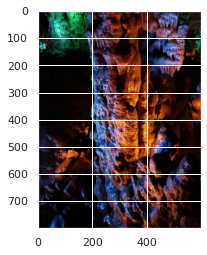

In [18]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = cv2.imread(img_path)
    plt.imshow(img[:,:,::-1])

    print(f"Suggested Locations: {predicted_landmarks}")


# test on a sample image
suggest_locations('/content/drive/MyDrive/ImageDatasets/images/test/24.Soreq_Cave/18dbbad48a83a742.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

- the top 1 suggestion provided by the algorithm for all the 4 test images supplied seem to be exact matches with the landmark locations. The output seems to be better than I expected. 

- Possible points of improvements:
1. Try out learning rate schedulers to exponentially decay learning rates during the training procedure. This could potentially lead to lower losses and hence higher accuracies as the optimizer navigates through the gradient descent landscape less erratically to reach the global minimum.

2. Try out fine tuning with the proposed architecture where increasingly preceeding layers in the CNN are trained and gradually allowed to learn to extract features from the dataset. Full network fine tuning can often have higher accuracy than ImageNet pretrained models.

3. Introduce even more forms of data augmentation like synthetic image generation through GAN's , random crops or implement multimodel ensembling to increase model performance and accuracy.

Suggested Locations: ['05.London_Olympic_Stadium', '40.Stockholm_City_Hall', '14.Terminal_Tower']


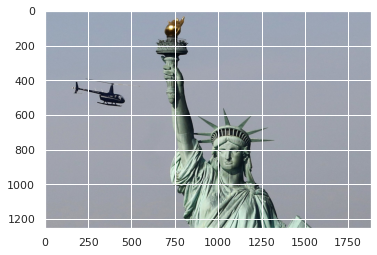

In [19]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('/content/drive/MyDrive/ImageDatasets/images/test_images_from_computer/liberty.jpg')
print("=" * 50)

Suggested Locations: ['32.Hanging_Temple', '11.Mount_Rushmore_National_Memorial', '44.Trevi_Fountain']


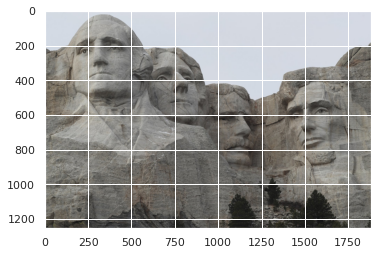

In [20]:
suggest_locations('/content/drive/MyDrive/ImageDatasets/images/test_images_from_computer/rushmore.jpg')
print("=" * 50)

Suggested Locations: ['33.Sydney_Opera_House', '28.Sydney_Harbour_Bridge', '38.Forth_Bridge']


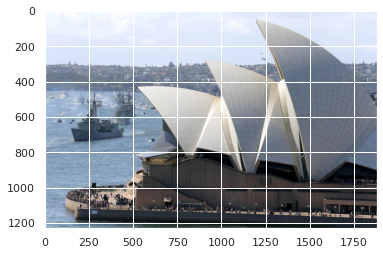

In [21]:
suggest_locations('/content/drive/MyDrive/ImageDatasets/images/test_images_from_computer/sydney_opera.jpg')
print("=" * 50)


Suggested Locations: ['35.Monumento_a_la_Revolucion', '21.Taj_Mahal', '40.Stockholm_City_Hall']


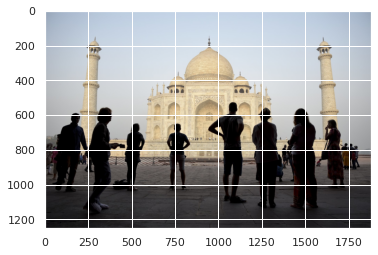

In [22]:
suggest_locations('/content/drive/MyDrive/ImageDatasets/images/test_images_from_computer/tajmahal.jpg')
print("=" * 50)